## Imports

In [18]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import STL, seasonal_decompose
from statsmodels.tsa.stattools import adfuller

from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly

import warnings
warnings.filterwarnings('ignore')

In [3]:
DATASET_FOLDER = 'dataset'
CSV_FILES = ['2010.csv', '2011.csv', '2012.csv', '2013.csv', '2014.csv', '2015.csv', '2016.csv', '2017.csv']

## Preprocessing data

Apply the same preprocessing operations as in the EDA investigation

In [4]:
def preprocessing(df):
    # Drop rows with null values
    df = df.dropna()

    # Drop non regular rows
    df = df[df.desc == "REGULAR"]

    # Combine the columns 'ca', 'unit' and 'scp' into a new one called 'turnstile'
    df['turnstile'] = df['ca'] + '-' + df['unit'] + '-' + df['scp']

    # Create a separate columns for date and time
    df['datetime'] = pd.to_datetime(df.time)

    # Drop duplicates
    df.drop_duplicates(subset=['station', 'linename', 'turnstile', 'datetime'], keep='first', inplace=True)

    # Ensure rows are sorted by time
    df = df.sort_values(['station', 'turnstile', 'datetime']).reset_index()
        
    # Calculate diff entries and exits
    df_turnstile_group = df.groupby('turnstile')
    df['diff_entries'] = df_turnstile_group['entries'].diff().fillna(0)
    df['diff_exits'] = df_turnstile_group['exits'].diff().fillna(0)
    
    # Remove outliers
    for key in ["diff_entries", "diff_exits"]:
        median_value = df[key].median()
        df[key][df[key] < 0] = median_value
        df[key][df[key] > df[key].quantile(0.99)] = median_value
    
    # Combine entries and exits into a new variable called traffic
    df['traffic'] = df['diff_entries'] + df['diff_exits']
    
    # Group traffic by station and linename
    df_station = df.groupby(['station', df.datetime.dt.to_period('D')]).traffic.sum().reset_index()
    df_line = df.groupby(['linename', df.datetime.dt.to_period('D')]).traffic.sum().reset_index()
    
    return df_station, df_line


### Generating Datasets

The csv files are relatively large and may not fit in memory, so processing must be done in chunks.

In [5]:
chunksize = 10 ** 6

df_st = pd.DataFrame()
df_ln = pd.DataFrame()
    
# Processing all CSV FILES. Obs: This operation can take a few minutes.
for csv_file in CSV_FILES:
    print("Processing:", csv_file)
    
    for df_chunk in pd.read_csv(os.path.join(DATASET_FOLDER, csv_file), chunksize=chunksize):
        df_st_c, df_ln_c = preprocessing(df_chunk)
        df_st = pd.concat((df_st, df_st_c))
        df_ln = pd.concat((df_ln, df_ln_c))

# Sort dataframes
df_st = df_st[2:-1].sort_values(['station', 'datetime']).reset_index()
df_ln = df_ln[2:-1].sort_values(['linename', 'datetime']).reset_index()

# Save them
df_st.to_csv(os.path.join(DATASET_FOLDER, 'daily_traffic_by_station.csv'), index=False)
df_ln.to_csv(os.path.join(DATASET_FOLDER, 'daily_traffic_by_line.csv'), index=False)

Processing: 2010.csv
Processing: 2011.csv
Processing: 2012.csv
Processing: 2013.csv
Processing: 2014.csv
Processing: 2015.csv
Processing: 2016.csv
Processing: 2017.csv


## Analyzing the Time Series

In [5]:
# Load dataset
df_st = pd.read_csv(os.path.join(DATASET_FOLDER, 'daily_traffic_by_station.csv'), parse_dates=["datetime"])
df_ln = pd.read_csv(os.path.join(DATASET_FOLDER, 'daily_traffic_by_line.csv'), parse_dates=["datetime"])
df_tot = df_ln.groupby('datetime').traffic.sum().reset_index()

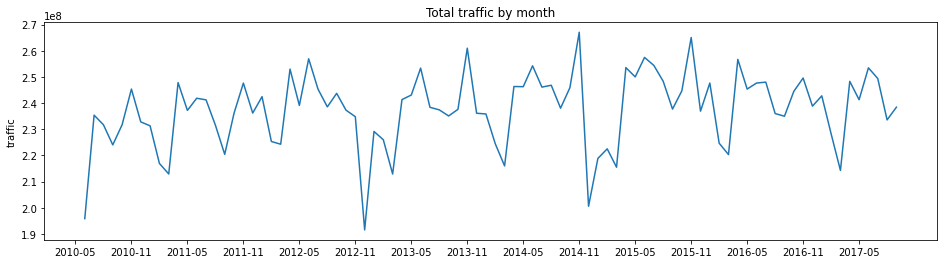

In [6]:
data = df_tot.groupby(df_tot.datetime.dt.to_period("M")).traffic.sum().reset_index()
data = data[1:-1] # Remove the first and last month
plt.figure(figsize=(16, 4))
sns.lineplot(data=data, x=data.index, y="traffic").set(title="Total traffic by month")
plt.xticks(range(len(data.index))[::6], data.datetime[::6]);

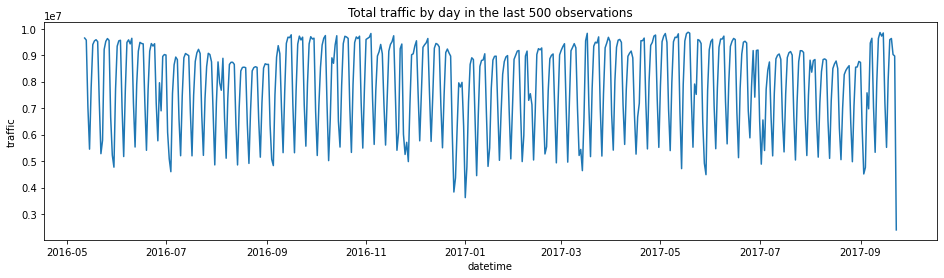

In [133]:
random_station = df_st.sample(1).station.values[0]
plt.figure(figsize=(16, 4))
df_split = df_tot.set_index('datetime')[-500:]
sns.lineplot(data=df_split, x='datetime', y='traffic').set(title="Total traffic by day in the last 500 observations");

### Check if our time serie is stationary

In [143]:
# Dickey-Fuller test to check if the time series data is stationary
result = adfuller(df_tot.traffic)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -7.798042
p-value: 0.000000
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567


Our ADF Statistic (-7.798) is lower than the 1% critical value of -3.433.
So it suggests that we can reject the null hypothesis with a significance level of less than 1%.
Which means that our time serie can be considered as stationary and have no time dependent-structure.

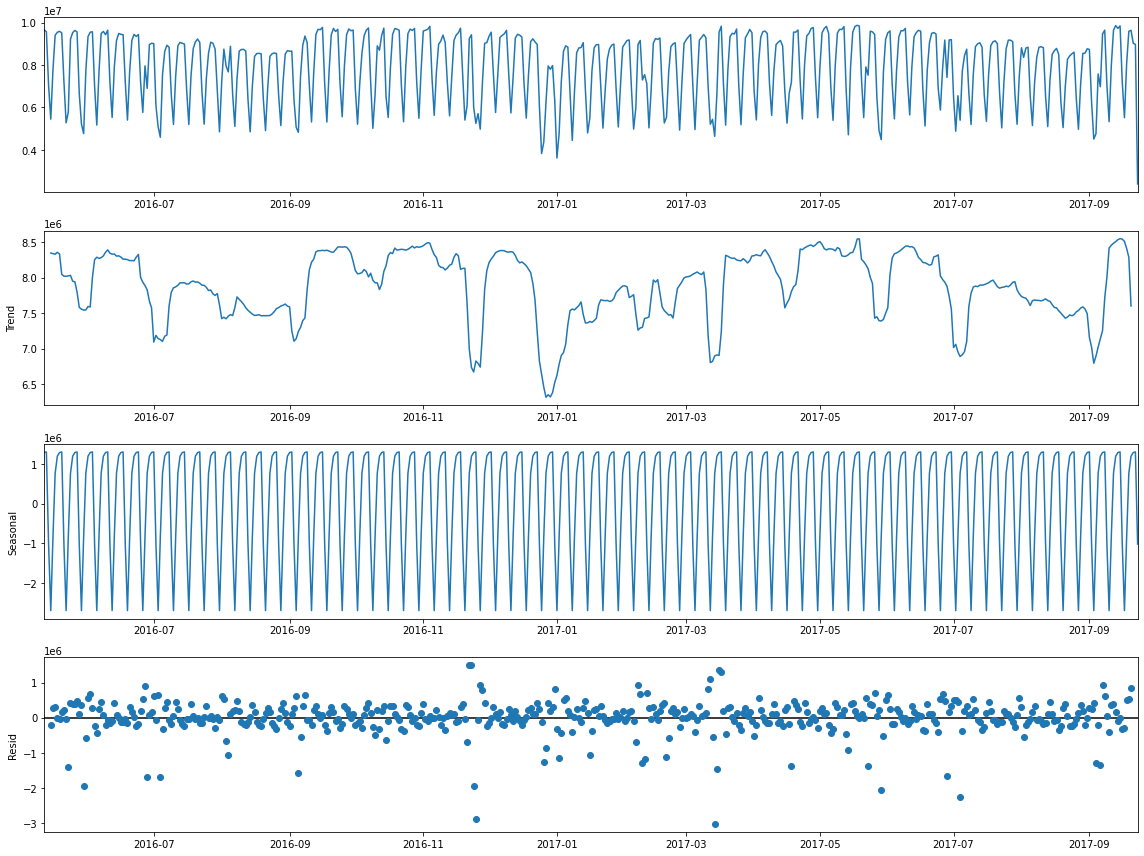

In [145]:
decompose = seasonal_decompose(df_tot[-500:].set_index('datetime'), period=7)
plt.rc("figure", figsize=(16, 12))
decompose.plot();

## Forecasting

In [146]:
!pip install prophet

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 35.2 MB/s eta 0:00:00 MB/s eta 0:00:01:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 46.6 MB/s eta 0:00:0031m47.5 MB/s eta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.9/47.9 kB 153.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.9/73.9 kB 127.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.1/179.1 kB 69.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.3/45.3 kB 162.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 43.3 MB/s eta 0:00:0031m41.8 MB/s eta 0:00:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 50.5 MB/s eta 0:00:00m eta 0:00:01
  Created wheel for pymeeus: filename=PyMeeus-0.5.11-py3-none-any.whl size=730971 sha256=559494eae03fea901b73a35f237878a9bb1949b0df53531d51b299e7707e82fd
  Stored in

In [9]:
m = Prophet()
m.fit(df_tot.rename(columns = {'datetime':'ds', 'traffic':'y'}))

19:01:36 - cmdstanpy - INFO - Chain [1] start processing
19:01:36 - cmdstanpy - INFO - Chain [1] done processing


In [22]:
future = m.make_future_dataframe(periods=365)
future.tail()

,ds
3065,2018-09-19
3066,2018-09-20
3067,2018-09-21
3068,2018-09-22
3069,2018-09-23


In [23]:
# Forecasting
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
3065,2018-09-19,9.316264e+06,8.168272e+06,1.036817e+07
3066,2018-09-20,9.375279e+06,8.375119e+06,1.054399e+07
3067,2018-09-21,9.442755e+06,8.424596e+06,1.054768e+07
3068,2018-09-22,7.285443e+06,6.275838e+06,8.366208e+06
3069,2018-09-23,5.759774e+06,4.664069e+06,6.772673e+06


In [25]:
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2010-04-17,7.610483e+06,5.617287e+06,7.757674e+06,7.610483e+06,7.610483e+06,-8.895761e+05,-8.895761e+05,-8.895761e+05,-1.020940e+06,-1.020940e+06,-1.020940e+06,131363.705438,131363.705438,131363.705438,0.0,0.0,0.0,6.720907e+06
1,2010-04-18,7.610646e+06,4.075893e+06,6.288910e+06,7.610646e+06,7.610646e+06,-2.444722e+06,-2.444722e+06,-2.444722e+06,-2.580086e+06,-2.580086e+06,-2.580086e+06,135364.875039,135364.875039,135364.875039,0.0,0.0,0.0,5.165924e+06
2,2010-04-19,7.610809e+06,5.918505e+06,8.083018e+06,7.610809e+06,7.610809e+06,-5.849657e+05,-5.849657e+05,-5.849657e+05,-7.292704e+05,-7.292704e+05,-7.292704e+05,144304.624988,144304.624988,144304.624988,0.0,0.0,0.0,7.025843e+06
3,2010-04-20,7.610972e+06,7.589058e+06,9.675938e+06,7.610972e+06,7.610972e+06,1.027217e+06,1.027217e+06,1.027217e+06,8.690297e+05,8.690297e+05,8.690297e+05,158187.288616,158187.288616,158187.288616,0.0,0.0,0.0,8.638189e+06
4,2010-04-21,7.611135e+06,7.765563e+06,1.000133e+07,7.611135e+06,7.611135e+06,1.313744e+06,1.313744e+06,1.313744e+06,1.136868e+06,1.136868e+06,1.136868e+06,176875.113040,176875.113040,176875.113040,0.0,0.0,0.0,8.924878e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3065,2018-09-19,7.793918e+06,8.168272e+06,1.036817e+07,7.784740e+06,7.802803e+06,1.522346e+06,1.522346e+06,1.522346e+06,1.136868e+06,1.136868e+06,1.136868e+06,385477.606333,385477.606333,385477.606333,0.0,0.0,0.0,9.316264e+06
3066,2018-09-20,7.793769e+06,8.375119e+06,1.054399e+07,7.784563e+06,7.802711e+06,1.581509e+06,1.581509e+06,1.581509e+06,1.149732e+06,1.149732e+06,1.149732e+06,431777.544065,431777.544065,431777.544065,0.0,0.0,0.0,9.375279e+06
3067,2018-09-21,7.793621e+06,8.424596e+06,1.054768e+07,7.784386e+06,7.802622e+06,1.649134e+06,1.649134e+06,1.649134e+06,1.174667e+06,1.174667e+06,1.174667e+06,474467.639685,474467.639685,474467.639685,0.0,0.0,0.0,9.442755e+06
3068,2018-09-22,7.793472e+06,6.275838e+06,8.366208e+06,7.784194e+06,7.802537e+06,-5.080284e+05,-5.080284e+05,-5.080284e+05,-1.020940e+06,-1.020940e+06,-1.020940e+06,512911.399173,512911.399173,512911.399173,0.0,0.0,0.0,7.285443e+06


In [16]:
plot_plotly(m, forecast)

In [17]:
plot_components_plotly(m, forecast)